# Ajustando un modelo de regresión adecuado para las series de tiempo de Ecobici

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
import datetime as dt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 10

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

from IPython.display import Image

Todas las metodologías para realizar un análisis sobre series de tiempo asumen que éstas son estacionarias. Una señal estacionaria es de utilidad en estos estudios porque con ella podemos extraer medias, desviación estándar y autocorrelación, propiedades que ayudan a estimar posibles estados futuros. Para que una estación sea estacionaria debe de cumplir una serie de requisitos:

- Que los valores de la serie de tiempo no contengan una tendencia (Un aumento progresivo en sus valores con el tiempo).
- La variación, media y autocorrelación de la serie de tiempo sea constante con el tiempo.

Obtener estas propiedades de una serie de tiempo que no es estacionaria conlleva a obtener valores mal calculados de media, varianza y correlación que no son de utilidad al momento de realizar una predicción.

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=18,center=False).mean()
    rolstd = timeseries.rolling(window=18,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries.values.ravel(), autolag='AIC', maxlag=18)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

### Preparación de la serie de tiempo.

Se toman los conteos de entradas de bicicletas por estación en cada hora para realizar la regresión en las serie de tiempo. Además de realizar de eliminación en datos que no se consideran relevantes:

- Eliminación de viajes etiquetados como cancelados.
- Eliminación de viajes de estaciones con IDs inexistentes.
- Se removieron los conteos en los horarios que el sistema no ofrece servicio, reteniendo solo los conteos de 6:00-23:00 y así, reduciendo el periodo de estacionalidad de 24 a 18 horas.

In [3]:
path = """D:\ownCloud\Documentos posgrado\Posgrado 2do semestre\Seminario investigacion\
       Experimental Data\Cd Mex\Movilidad\Hist Ecobici\ecobici.csv'"""
trips = pd.read_csv(path,
                    parse_dates=['date_removed', 'date_arrived'],
                    infer_datetime_format=True,
                    low_memory=False)

# Find the start date
ind = pd.DatetimeIndex(trips.date_arrived)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

trips = trips.loc[trips['action'] != 'C  ']

idx = pd.date_range(trips.date.min(), trips.date.max() + dt.timedelta(days=1), freq='H')

by_hour = (trips
     .set_index('date_arrived')
     .groupby([pd.TimeGrouper('H'), 'station_arrived'])
     .station_arrived
     .count()
     .unstack()
     .reindex(idx)
     .fillna(0)
     )

by_hour.drop([col for col in list(by_hour.columns.values) if col > 275], axis=1, inplace=True)
by_hour = by_hour[by_hour.index.dayofweek < 5]
by_hour = by_hour.between_time('6:00','23:00')

*Nota:
Solo con meros fines ilustrativos los análisis que se realicen en este notebook se realizarán a la estación 1 ubicado en RIO BALSAS-RIO SENA.

### Prueba estacionaria para la señal.

La siguiente función regresa los siguientes elementos que se toman en consideración para determinar si la señal en conteos de la estación es estacionaria o no:

- Resultado de la prueba Dickey-Fuller
- Actividad de conteos de la estación a lo largo de 4 años (azul)
- Media movil de la señal (rojo)
- Desviación estándar de la señal (negro)

Se muestra un gráfico muy comprimido debido a la cantidad de datos que se están graficando, en las siguientes presentaciones planeo mostrar gráficos interactivos en los que se pueda hacer acercamientos a la serie de tiempo. Por el momento estoy experimentando problemas con las librerías, es por eso que decidí realizar el gráfico de esta manera.

Results of Dickey-Fuller Test:
Test Statistic                -6.483319e+00
p-value                        1.278955e-08
#Lags Used                     1.700000e+01
Number of Observations Used    1.830600e+04
Critical Value (5%)           -2.861698e+00
Critical Value (1%)           -3.430707e+00
Critical Value (10%)          -2.566854e+00
dtype: float64


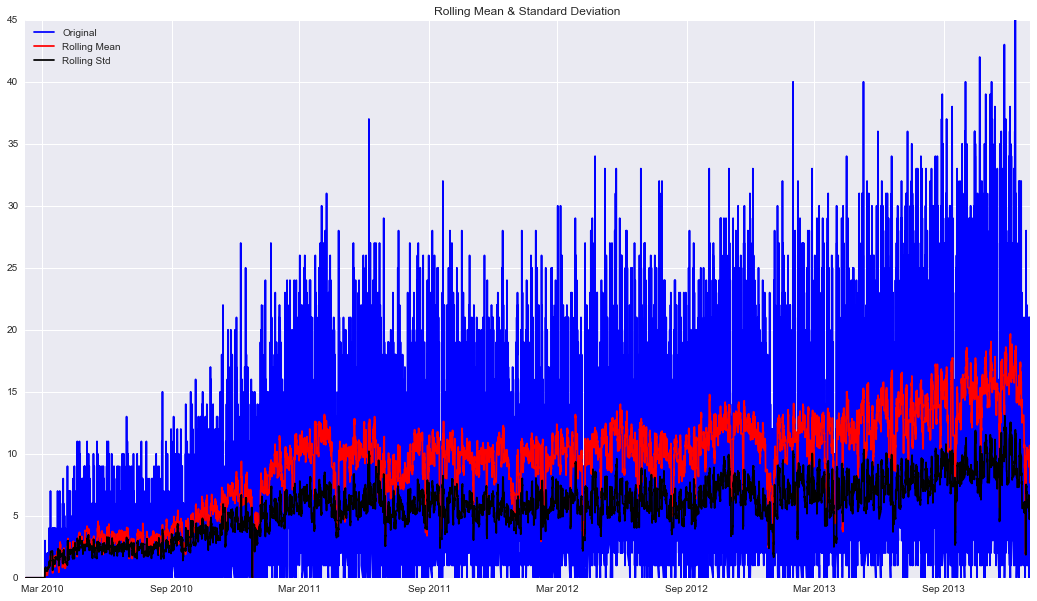

In [4]:
test_stationarity(by_hour[[1]])

El resultado de la prueba Dickey-Fuller indica que la serie con la que se está trabajando es estacionaria en un 100% de los datos pero si se presta atención a los gráficos se puede ver que la señal tiene una tendencia, su variabilidad y su media incrementa con el tiempo lo cual hablan de una señal no estacionaria. Debido a lo anterior la señal será transformada para obtener una señal estacionaria.

### ACF y PACF de la señal

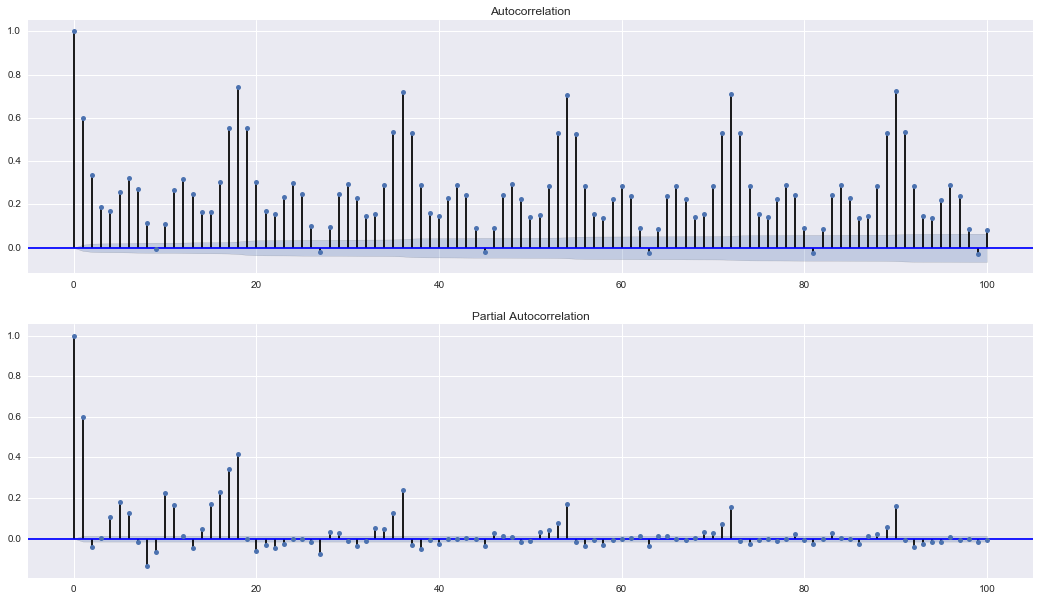

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(by_hour[[1]].values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(by_hour[[1]], lags=100, ax=ax2)

Los anteriores gráficos reciben el nombre de correlogramas y estos pertenecen a la función de autocorrelación(ACF) y función de autocorrelación parcial(PACF). Lo que estos gráficos explican es el grado de correlación que existe con ella misma en un retardo (Lag) T. La función de autocorrelación muestra un caracter oscilatorio que no disminuye con el tiempo, Eso nos dice que la señal conserva las características de estacionalidad y de tendencia.

### Penalizando la variabilidad

Para obtener un grado de variabilidad más constante del que se tiene ahora se aplica una funcion logarítmica a la serie de tiempo. En la serie de tiempo hay momentos en donde los conteos de bicicletas llegan a 0 y el logaritmo de 0 no está definido, es por eso que primero se aplica una suma a la serie de tiempo.

In [6]:
logged_ts = by_hour + 1
logged_ts = logged_ts.apply(np.log)

# deal with missing values. see issue
logged_ts.interpolate(inplace=True)

Results of Dickey-Fuller Test:
Test Statistic                -6.333779e+00
p-value                        2.863618e-08
#Lags Used                     1.800000e+01
Number of Observations Used    1.830500e+04
Critical Value (5%)           -2.861698e+00
Critical Value (1%)           -3.430707e+00
Critical Value (10%)          -2.566854e+00
dtype: float64


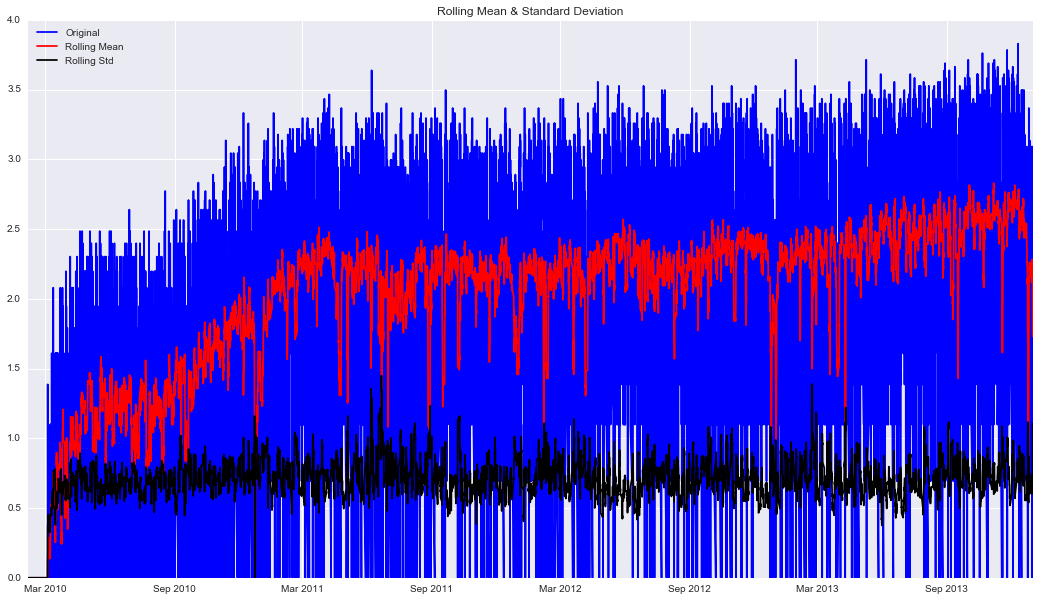

In [7]:
test_stationarity(logged_ts[[1]])

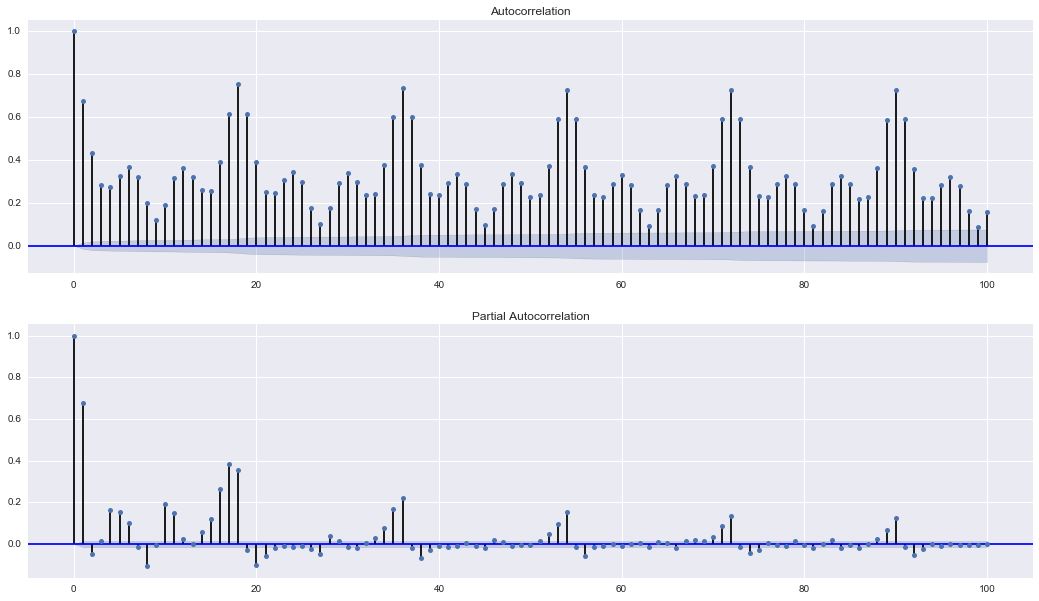

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(logged_ts[[1]].values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(logged_ts[[1]], lags=100, ax=ax2)

### Eliminando la tendencia.

Otro procedimiento al que hay que someter a la serie de tiempo antes de comenzar con el análisis es eliminar su tendencia. 

In [ ]:
# Differencing by hour forces us to drop the first value.
d_logged_ts = (logged_ts - logged_ts.shift())[1:]

In [ ]:
test_stationarity(d_logged_ts[[1]])

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(d_logged_ts[[1]].values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(d_logged_ts[[1]], lags=100, ax=ax2)

El correlograma muestra que la serie de tiempo sigue teniendo picos de correlación a tiempos 18T. Lo que puede indicarnos que sigue conservando su estacionalidad y que la serie de tiempo esta subdiferenciada.

### Aplicando una diferenciación estacional.

La diferenciación estacional a menudo remueve los valores crudos de estacionalidad en las series de tiempo. También una diferenciación estacional integrada al modelo SARIMA impide que el componente estacional de desaparecer en las predicciones a largo plazo.

In [ ]:
sd_d_logged_ts = (d_logged_ts - d_logged_ts.shift(18))[18:]

In [ ]:
test_stationarity(sd_d_logged_ts[[1]])

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sd_d_logged_ts[[1]].values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sd_d_logged_ts[[1]], lags=100, ax=ax2)

La señal obtenida en la serie de tiempo tiene un comportamiento particular. El ACF tiene un fuerte pico negativo en el primer lag y el PACF, si solo nos quedamos con los retardos múltiplos de la estacionalidad (18), nos podemos dar cuenta que está disminuyendo linealmente.

De los modelos de guía que ofrece el libro de econometría de Muñoz y Parra, nos indica que este comportamiento, tal como esta, y cuyos picos resaltantes son negativos, usar un modelo $ARIMA(0,0,1)x(0,0,1)_{18}$, es decir, un modelo arima con un termino MA(Moving Average) para modelar la parte no estacional y un término SMA (Seasonal Moving Average) para modelar la parte estacional.

Claro, integrando las diferenciaciones que he estado mostrando hasta el momento, nos quedamos con un modelo $ARIMA(0,1,1)x(0,1,1)_{18}$, mejor conocido como "seasonal exponential smoothing" model, muy usual en las series de tiempo con una estacionalidad estable:

"Probably the most commonly used seasonal ARIMA model is the (0,1,1)x(0,1,1) model--i.e., an MA(1)xSMA(1) model with both a seasonal and a non-seasonal difference. This is essentially a "seasonal exponential smoothing" model."

In [ ]:
Image(filename=r'C:\Users\ghost\Desktop\pruebas\ECOBICI_data\ACF.PNG') 

In [ ]:
test = logged_ts['2013-11-29']
logged_ts = logged_ts['2010-03-01':'2013-11-28']

### Usando el modelo SARIMA desde la librería de R

In [ ]:
import statsmodels.api as sm
import rpy2.robjects as R
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [ ]:
%load_ext rpy2.ipython

In [ ]:
stats = importr('stats')
tseries = importr('tseries')

In [ ]:
r_df = pandas2ri.py2ri(logged_ts[[1]])
y = stats.ts(r_df)

In [ ]:
order = R.IntVector((0,1,1))

In [ ]:
season = R.ListVector({'order': R.IntVector((0,1,1)), 'period' : 18})

In [ ]:
model = stats.arima(y, order = order, seasonal=season)

In [ ]:
%Rpush model
%R tsdiag(model, 100)

El gráfico anterior nos ofrece formas para evaluar qué tan bien se ajustó el modelo a la serie de tiempo. Los valores residuales muestran un error que +-2 para la serie de tiempo log, el ACF de los residuos muestran que, salvo por un pequeño pico en el Lag 1, la señal residual puede considerarse como ruido blanco, el gráfico de al final muestra un valor de significancia despreciable sobre los valores residuales.

### Predicción para la serie de tiempo.

Para la serie de tiempo en este caso se deparó una predicción de 18 puntos en el futura el día noviembre 29 del 2013, un viernes de quincena.

In [ ]:
forecast = importr('forecast')

El siguiente gráfico resalta 48 puntos en el pasado para la serie de tiempo de entrenamiento (azul), la actividad que hubo para el día de prueba (verde) y el resultado en la predicción para el día de prueba (rojo).

In [ ]:
f = forecast.forecast(model,18)
pred = [i[1] for i in f[3].items()]
dt = test.index
pr = pd.Series(pred, index = dt)

logged_ts[[1]][-48:].plot()
test[1].plot(color = 'green', legend='test')
pr.plot(color = 'red', legend='prediction')

La predicción se realizó para un solo día en este caso debido a que el modelo diferenciado asume una tendencia variable en tiempo. Los modelos que asumen una tendencia constante son más confiables para realizar predicciones a largo plazo además, si la asusción es correcta.

### Trabajo posterior a haber realizado esto:

Una vez con el modelo SARIMA más adecuado para hacer pronósticos sobre la serie de tiempo, lo que prosigue es realizar un submuestreo en las estaciones que forman parte en el head, body y tail en rank diversity, medir sus errores de predicción para dar continuación a la hipótesis de que en sistemas como estos solo es posible/conveniente realizar la predicción sobre estaciones que forman parte del head.

- Separar la serie de tiempo en una proporción de 80% para el entrenamiento y realizar una predicción para el 20% de los datos restantes, para estaciones en head, body y tail
- Hacer una comparativa con dos diferentes métodos de regresión:
    1) Arima, 2) Sarima
    a) las graficas de las series de tiempo.
    b) medidas RMSE(Root Mean Square Error) y MAE(Mean Absolute Error) para las predicciones.



In [9]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

# create a new plot with a datetime axis type
p = figure(width=1000, height=500, x_axis_type="datetime")

p.line(logged_ts.index, logged_ts[[1]], color='navy', alpha=0.5)

show(p)

Loading BokehJS ...